Here's my notebook where I ran starfysh. 

For my set up, I needed to make a new environment, then do 

pip install Starfysh

and then 

pip install histomicstk --find-links https://girder.github.io/large_image_wheels

and it should work fine. Not sure how to get PoE working here... if you figure it out, let me know.


In [1]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib import rcParams

import seaborn as sns
sns.set_style('white')

font_list = []
fpaths = matplotlib.font_manager.findSystemFonts()
for i in fpaths:
    try:
        f = matplotlib.font_manager.get_font(i)
        font_list.append(f.family_name)
    except RuntimeError:
        pass

font_list = set(font_list)
plot_font = 'Helvetica' if 'Helvetica' in font_list else 'FreeSans'

rcParams['font.family'] = plot_font
rcParams.update({'font.size': 10})
rcParams.update({'figure.dpi': 300})
rcParams.update({'figure.figsize': (3,3)})
rcParams.update({'savefig.dpi': 500})

import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd

# read your CSV
df = pd.read_csv("../data/cell_markers/normalized_cellmarkers2.csv")

# for each cell_type, get the list of marker genes
grouped = df.groupby("cell_type")["marker_gene"].apply(list)

# convert to a dataframe where each column is a cell type
# and each row contains a marker at that index
wide = pd.DataFrame.from_dict(grouped.to_dict(), orient="index").T

# save
wide.to_csv("../data/cell_markers/signatures.csv", index=False)


In [3]:
from starfysh import (AA, utils, plot_utils, post_analysis)
from starfysh import starfysh as sf_model

In [4]:
# Specify data paths
data_path = '../data'
sample_id = 'visium_adult_mouse_brain'
sig_name = 'signatures.csv'

In [5]:
print(os.path.join(data_path, sample_id, 'filtered_feature_bc_matrix.h5'))

../data/visium_adult_mouse_brain/filtered_feature_bc_matrix.h5


In [6]:
# Load expression counts and signature gene sets
adata, adata_normed = utils.load_adata(data_folder=data_path,
                                       sample_id=sample_id, # sample id
                                       n_genes=2000  # number of highly variable genes to keep
                                       )


[2025-11-22 12:38:46] Preprocessing1: delete the mt and rp
[2025-11-22 12:38:47] Preprocessing2: Normalize
[2025-11-22 12:38:47] Preprocessing3: Logarithm
[2025-11-22 12:38:48] Preprocessing4: Find the variable genes


In [7]:
gene_sig = pd.read_csv(os.path.join(data_path, sig_name))
gene_sig = utils.filter_gene_sig(gene_sig, adata.to_df())
gene_sig.head()

Activated neural stem cell Astrocyte Basket cell Bergmann glial cell  \
0                       Csf3     Acsl3      Cartpt             Aldh1l1   
1                      Fbxo2     Acsl6      Cox6a2                Aqp4   
2                      Fxyd1       Agt      Eif5a2            Arhgef26   
3                       Gfap      Aqp4       Esrrg             Arhgef4   
4                        Id3   Atp13a4        Etv6              Bmpr1b   

  CCK basket cell Cajal-Retzius cell Chandelier cell Dorsal otocyst  \
0          Cadps2      5330417C22Rik           Cpne5           Bmp4   
1           Ccnd3               Aatf          Dusp14           Dlx5   
2            Cnr1             Angpt1          Errfi1           Emx2   
3         Col15a1            B3galt1         Fam163b          Fgfr3   
4           Cryab                Bbx           Fgf13            Fst   

  Early intermediate precursor cell Early neuroblast  ... Precursor cell  \
0                             Sox11           Acvr2a  ...        Neurod1   
1                               NaN            Fgf10  ...        Neurog1   
2                               NaN             Fgf3  ...            NaN   
3                               NaN             Fgf8  ...            NaN   
4                               NaN             Hes5  ...            NaN   

  Progenitor cell Quiescent neural stem cell Smooth muscle cell  \
0           Ascl1                      Aldoc              Abcc9   
1             NaN                     Atp1a2              Adap2   
2             NaN                        Clu               Airn   
3             NaN                       Gja1               Ano1   
4             NaN                      Htra1           Arhgap42   

  Type I spiral ganglion neuron Type IA spiral ganglion neuron  \
0                 0610030E20Rik                  1700025G04Rik   
1                 1110017D15Rik                  2510009E07Rik   
2                 1700025G04Rik                  A330074K22Rik   
3                 1700030K09Rik                          Actn2   
4                 1700066M21Rik                        Adamts5   

  Type IB spiral ganglion neuron Type IC spiral ganglion neuron  \
0                        Ankrd16                  6330403K07Rik   
1                          Anxa5                         Adam11   
2                          Apex2                         Adgra1   
3                           Bcam                         Adgrb3   
4                          Btbd9                        Adprhl1   

  Type II spiral ganglion neuron Ventral otocyst  
0                  1600002K03Rik           Fbxo2  
1                  1700001K19Rik            Fzd8  
2                  1700006F04Rik            Gli1  
3                  1700019D03Rik            Hes1  
4                  1700023F06Rik            Hey2  

[5 rows x 40 columns]

In [8]:
adata

AnnData object with n_obs × n_vars = 2702 × 21936
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable'
    uns: 'spatial'
    obsm: 'spatial'

In [9]:
gene_sig

Activated neural stem cell Astrocyte Basket cell Bergmann glial cell  \
0                          Csf3     Acsl3      Cartpt             Aldh1l1   
1                         Fbxo2     Acsl6      Cox6a2                Aqp4   
2                         Fxyd1       Agt      Eif5a2            Arhgef26   
3                          Gfap      Aqp4       Esrrg             Arhgef4   
4                           Id3   Atp13a4        Etv6              Bmpr1b   
...                         ...       ...         ...                 ...   
1081                        NaN       NaN         NaN                 NaN   
1082                        NaN       NaN         NaN                 NaN   
1083                        NaN       NaN         NaN                 NaN   
1084                        NaN       NaN         NaN                 NaN   
1085                        NaN       NaN         NaN                 NaN   

     CCK basket cell Cajal-Retzius cell Chandelier cell Dorsal otocyst  \
0             Cadps2      5330417C22Rik           Cpne5           Bmp4   
1              Ccnd3               Aatf          Dusp14           Dlx5   
2               Cnr1             Angpt1          Errfi1           Emx2   
3            Col15a1            B3galt1         Fam163b          Fgfr3   
4              Cryab                Bbx           Fgf13            Fst   
...              ...                ...             ...            ...   
1081             NaN                NaN             NaN            NaN   
1082             NaN                NaN             NaN            NaN   
1083             NaN                NaN             NaN            NaN   
1084             NaN                NaN             NaN            NaN   
1085             NaN                NaN             NaN            NaN   

     Early intermediate precursor cell Early neuroblast  ... Precursor cell  \
0                                Sox11           Acvr2a  ...        Neurod1   
1                                  NaN            Fgf10  ...        Neurog1   
2                                  NaN             Fgf3  ...            NaN   
3                                  NaN             Fgf8  ...            NaN   
4                                  NaN             Hes5  ...            NaN   
...                                ...              ...  ...            ...   
1081                               NaN              NaN  ...            NaN   
1082                               NaN              NaN  ...            NaN   
1083                               NaN              NaN  ...            NaN   
1084                               NaN              NaN  ...            NaN   
1085                               NaN              NaN  ...            NaN   

     Progenitor cell Quiescent neural stem cell Smooth muscle cell  \
0              Ascl1                      Aldoc              Abcc9   
1                NaN                     Atp1a2              Adap2   
2                NaN                        Clu               Airn   
3                NaN                       Gja1               Ano1   
4                NaN                      Htra1           Arhgap42   
...              ...                        ...                ...   
1081             NaN                        NaN                NaN   
1082             NaN                        NaN                NaN   
1083             NaN                        NaN                NaN   
1084             NaN                        NaN                NaN   
1085             NaN                        NaN                NaN   

     Type I spiral ganglion neuron Type IA spiral ganglion neuron  \
0                    0610030E20Rik                  1700025G04Rik   
1                    1110017D15Rik                  2510009E07Rik   
2                    1700025G04Rik                  A330074K22Rik   
3                    1700030K09Rik                          Actn2   
4                    1700066M21Rik                      

In [10]:
gene_sig["Neuron"]

0       6330403K07Rik
1               Agap2
2                Ahi1
3                Arf3
4              Atp1a3
            ...      
1081              NaN
1082              NaN
1083              NaN
1084              NaN
1085              NaN
Name: Neuron, Length: 1086, dtype: object

In [11]:
# Load spatial information
img_metadata = utils.preprocess_img(data_path,
                                    sample_id,
                                    adata_index=adata.obs.index)

print(img_metadata)
img = img_metadata['img']
map_info = img_metadata['map_info']

{'img': array([[[251, 254, 244],
        [252, 254, 244],
        [252, 254, 247],
        ...,
        [249, 253, 243],
        [248, 252, 246],
        [248, 251, 244]],

       [[251, 254, 245],
        [252, 254, 244],
        [251, 254, 246],
        ...,
        [246, 252, 241],
        [247, 252, 246],
        [248, 253, 248]],

       [[251, 254, 244],
        [253, 254, 247],
        [250, 254, 248],
        ...,
        [246, 252, 244],
        [247, 252, 246],
        [250, 253, 246]],

       ...,

       [[252, 254, 247],
        [251, 254, 246],
        [251, 254, 248],
        ...,
        [250, 254, 247],
        [250, 254, 246],
        [252, 254, 246]],

       [[251, 254, 249],
        [252, 254, 248],
        [251, 254, 246],
        ...,
        [250, 253, 246],
        [252, 254, 246],
        [253, 254, 246]],

       [[253, 254, 247],
        [252, 254, 247],
        [252, 254, 247],
        ...,
        [251, 254, 246],
        [251, 254, 245],
        [253, 25

In [12]:
img = img_metadata['img']
map_info = img_metadata['map_info']
if img.shape[2]==4:
    img = img[:,:,:3]
    img_metadata['img'] = img

[2025-11-22 12:38:51] findfont: Font family 'FreeSans' not found.
[2025-11-22 12:38:51] findfont: Font family 'FreeSans' not found.
[2025-11-22 12:38:51] findfont: Font family 'FreeSans' not found.
[2025-11-22 12:38:51] findfont: Font family 'FreeSans' not found.
[2025-11-22 12:38:51] findfont: Font family 'FreeSans' not found.
[2025-11-22 12:38:51] findfont: Font family 'FreeSans' not found.
[2025-11-22 12:38:51] findfont: Font family 'FreeSans' not found.
[2025-11-22 12:38:51] findfont: Font family 'FreeSans' not found.
[2025-11-22 12:38:51] findfont: Font family 'FreeSans' not found.
[2025-11-22 12:38:51] findfont: Font family 'FreeSans' not found.
[2025-11-22 12:38:51] findfont: Font family 'FreeSans' not found.
[2025-11-22 12:38:51] findfont: Font family 'FreeSans' not found.
[2025-11-22 12:38:51] findfont: Font family 'FreeSans' not found.
[2025-11-22 12:38:51] findfont: Font family 'FreeSans' not found.
[2025-11-22 12:38:51] findfont: Font family 'FreeSans' not found.
[2025-11-2

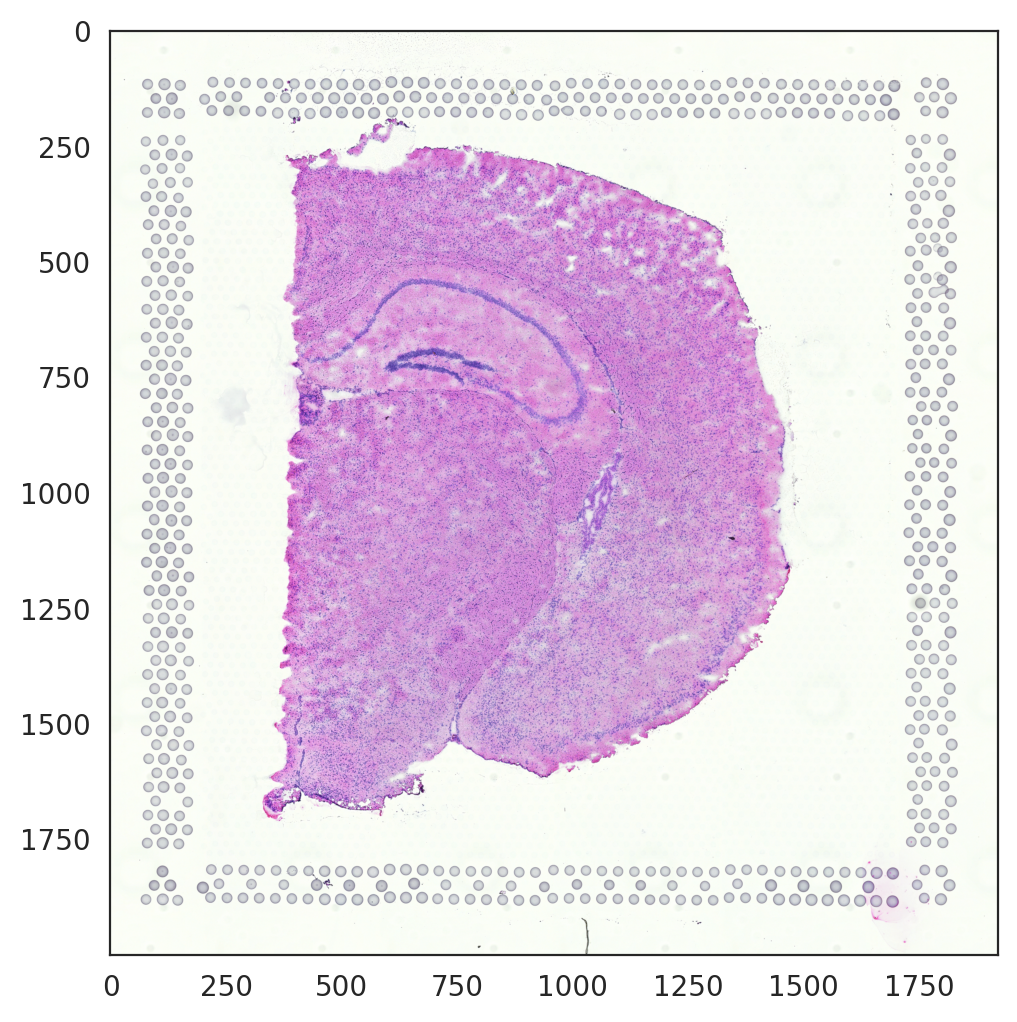

In [13]:
plt.figure(figsize=(6, 6), dpi=200)
plt.imshow(img)
plt.show()

In [14]:
import numpy as np
from scipy import sparse

if isinstance(adata.X, np.ndarray):
    x = adata.X
elif sparse.issparse(adata.X):
    x = adata.X.toarray()
else:
    x = np.asarray(adata.X)   # fallback

adata.X = x


if isinstance(adata_normed.X, np.ndarray):
    x = adata_normed.X
elif sparse.issparse(adata_normed.X):
    x = adata_normed.X.toarray()
else:
    x = np.asarray(adata_normed.X)   # fallback

adata_normed.X = x

In [15]:
# Parameters for training
visium_args = utils.VisiumArguments(adata,
                                    adata_normed,
                                    gene_sig,
                                    img_metadata,
                                    window_size=3, # adjust window_size for considering the neighbor density
                                    sample_id=sample_id)

# this code is necessar to update adata to include image info and loc info
adata, adata_normed = visium_args.get_adata()

[2025-11-22 12:38:52] Subsetting highly variable & signature genes ...
[2025-11-22 12:39:17] Smoothing library size by taking averaging with neighbor spots...
[2025-11-22 12:39:18] Retrieving & normalizing signature gene expressions...


[2025-11-22 12:39:29] Identifying anchor spots (highly expression of specific cell-type signatures)...


In [16]:
map_info = pd.DataFrame({
    "array_col": adata.obsm["spatial"][:, 0],
    "array_row": adata.obsm["spatial"][:, 1]
}, index=adata.obs_names)

[2025-11-22 12:39:29] findfont: Font family 'FreeSans' not found.
[2025-11-22 12:39:29] findfont: Font family 'FreeSans' not found.
[2025-11-22 12:39:29] findfont: Font family 'FreeSans' not found.
[2025-11-22 12:39:29] findfont: Font family 'FreeSans' not found.
[2025-11-22 12:39:29] findfont: Font family 'FreeSans' not found.
[2025-11-22 12:39:29] findfont: Font family 'FreeSans' not found.
[2025-11-22 12:39:29] findfont: Font family 'FreeSans' not found.
[2025-11-22 12:39:29] findfont: Font family 'FreeSans' not found.
[2025-11-22 12:39:29] findfont: Font family 'FreeSans' not found.
[2025-11-22 12:39:29] findfont: Font family 'FreeSans' not found.
[2025-11-22 12:39:29] findfont: Font family 'FreeSans' not found.
[2025-11-22 12:39:29] findfont: Font family 'FreeSans' not found.
[2025-11-22 12:39:29] findfont: Font family 'FreeSans' not found.
[2025-11-22 12:39:29] findfont: Font family 'FreeSans' not found.
[2025-11-22 12:39:29] findfont: Font family 'FreeSans' not found.
[2025-11-2

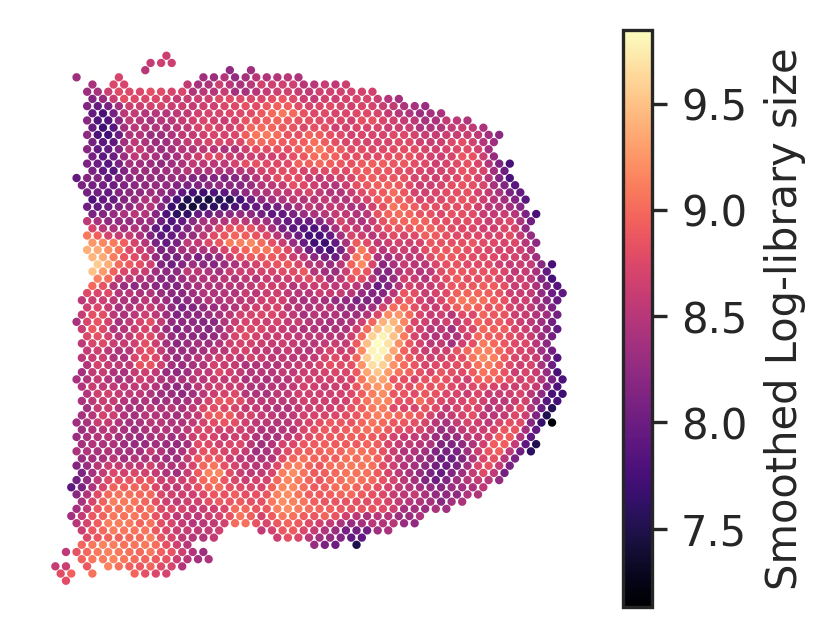

In [17]:
plot_utils.plot_spatial_feature( map_info = map_info,
                                 variable = visium_args.win_loglib,
                                 vmin=None,# adjust 
                                 vmax=None,# adjust 
                                 figsize = (3,2.5),
                                 label='Smoothed Log-library size' # label for the colorbar
                                )

[2025-11-22 12:39:29] findfont: Font family 'FreeSans' not found.
[2025-11-22 12:39:29] findfont: Font family 'FreeSans' not found.
[2025-11-22 12:39:29] findfont: Font family 'FreeSans' not found.
[2025-11-22 12:39:29] findfont: Font family 'FreeSans' not found.
[2025-11-22 12:39:29] findfont: Font family 'FreeSans' not found.
[2025-11-22 12:39:29] findfont: Font family 'FreeSans' not found.
[2025-11-22 12:39:29] findfont: Font family 'FreeSans' not found.
[2025-11-22 12:39:29] findfont: Font family 'FreeSans' not found.
[2025-11-22 12:39:29] findfont: Font family 'FreeSans' not found.
[2025-11-22 12:39:29] findfont: Font family 'FreeSans' not found.
[2025-11-22 12:39:29] findfont: Font family 'FreeSans' not found.
[2025-11-22 12:39:29] findfont: Font family 'FreeSans' not found.
[2025-11-22 12:39:29] findfont: Font family 'FreeSans' not found.
[2025-11-22 12:39:29] findfont: Font family 'FreeSans' not found.
[2025-11-22 12:39:29] findfont: Font family 'FreeSans' not found.
[2025-11-2

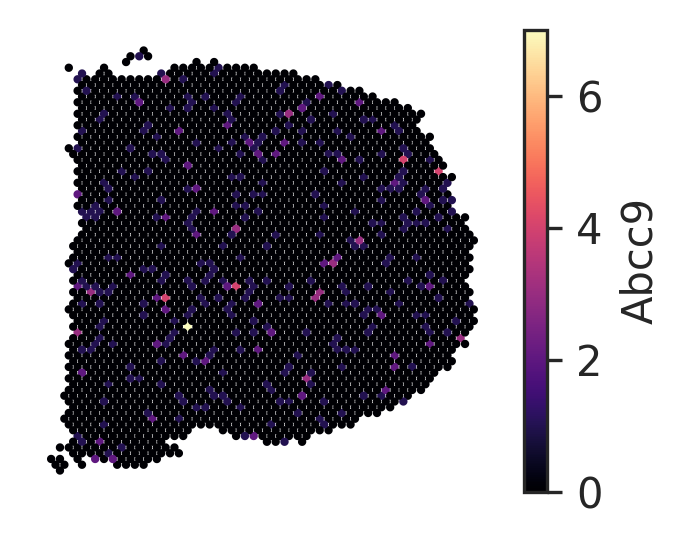

In [18]:
# plot for checking gene expression
plot_utils.plot_spatial_gene(adata,
                             map_info,
                             gene_name='Abcc9'
                            )

[2025-11-22 12:39:30] findfont: Font family 'FreeSans' not found.
[2025-11-22 12:39:30] findfont: Font family 'FreeSans' not found.
[2025-11-22 12:39:30] findfont: Font family 'FreeSans' not found.
[2025-11-22 12:39:30] findfont: Font family 'FreeSans' not found.
[2025-11-22 12:39:30] findfont: Font family 'FreeSans' not found.
[2025-11-22 12:39:30] findfont: Font family 'FreeSans' not found.
[2025-11-22 12:39:30] findfont: Font family 'FreeSans' not found.
[2025-11-22 12:39:30] findfont: Font family 'FreeSans' not found.
[2025-11-22 12:39:30] findfont: Font family 'FreeSans' not found.
[2025-11-22 12:39:30] findfont: Font family 'FreeSans' not found.
[2025-11-22 12:39:30] findfont: Font family 'FreeSans' not found.
[2025-11-22 12:39:30] findfont: Font family 'FreeSans' not found.
[2025-11-22 12:39:30] findfont: Font family 'FreeSans' not found.
[2025-11-22 12:39:30] findfont: Font family 'FreeSans' not found.
[2025-11-22 12:39:30] findfont: Font family 'FreeSans' not found.
[2025-11-2

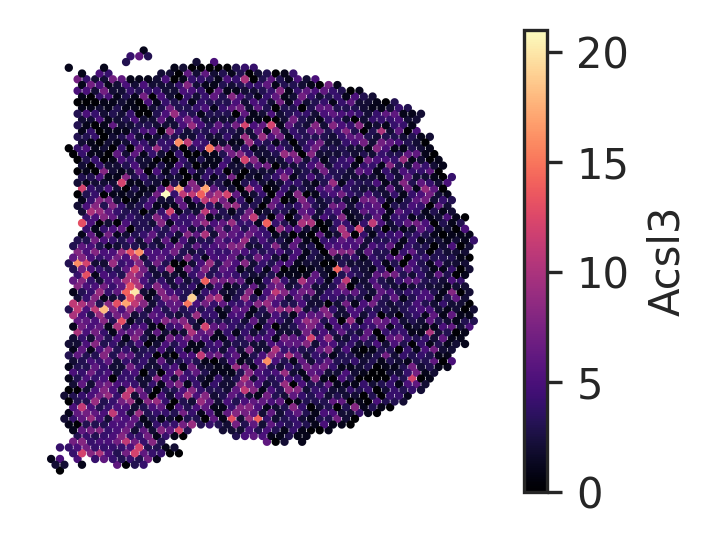

In [19]:
# plot for checking gene expression
plot_utils.plot_spatial_gene(adata,
                             map_info,
                             gene_name='Acsl3'
                            )

In [20]:
n_repeats = 1 # recommend >3 for selecting a better trained model 
epochs = 200
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [21]:
model, loss = utils.run_starfysh(visium_args,
                                 n_repeats=n_repeats,
                                 epochs=epochs,
                                 poe=False,
                                 device=device)

[2025-11-22 12:39:30] Running Starfysh with 1 restarts, choose the model with best parameters...
[2025-11-22 12:39:31] Initializing model parameters...
[2025-11-22 12:40:40] Epoch[10/200], train_loss: 4793.1845, train_reconst: 4557.5400, train_u: 17.8661,train_z: 32.8662,train_c: 183.9567,train_l: 0.9555
[2025-11-22 12:41:49] Epoch[20/200], train_loss: 4329.3926, train_reconst: 4115.6221, train_u: 17.6705,train_z: 32.0723,train_c: 162.3442,train_l: 1.6835
[2025-11-22 12:42:58] Epoch[30/200], train_loss: 4229.5866, train_reconst: 4025.9964, train_u: 17.5196,train_z: 31.2129,train_c: 152.7626,train_l: 2.0953
[2025-11-22 12:44:06] Epoch[40/200], train_loss: 4196.6353, train_reconst: 3999.0672, train_u: 17.3961,train_z: 30.1333,train_c: 147.6273,train_l: 2.4113
[2025-11-22 12:45:16] Epoch[50/200], train_loss: 4137.5885, train_reconst: 3944.6523, train_u: 17.2938,train_z: 29.5345,train_c: 143.4818,train_l: 2.6262
[2025-11-22 12:46:26] Epoch[60/200], train_loss: 4111.1448, train_reconst: 392

In [22]:
## information of inference_outputs and generative_outputs have been updated in adata_starfysh already
inference_outputs, generative_outputs = sf_model.model_eval(model,
                                                            adata,
                                                            visium_args,
                                                            device=device)

In [23]:
adata

AnnData object with n_obs × n_vars = 2702 × 4208
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable'
    uns: 'spatial', 'cell_types', 'pca', 'neighbors', 'umap', 'qu'
    obsm: 'spatial', 'X_pca', 'X_umap', 'px', 'qc_m', 'qc', 'qz_m', 'qz_m_ct', 'qz_logv', 'qz_logv_ct', 'qz', 'ql_m', 'ql_logv', 'ql', 'px_rate', 'pc_p', 'xs_k'
    varm: 'PCs', 'px_r'
    obsp: 'distances', 'connectivities'

In [24]:
adata.uns['cell_types']

['Activated neural stem cell',
 'Astrocyte',
 'Basket cell',
 'Bergmann glial cell',
 'CCK basket cell',
 'Cajal-Retzius cell',
 'Chandelier cell',
 'Dorsal otocyst',
 'Early intermediate precursor cell',
 'Early neuroblast',
 'Endothelial cell',
 'Ependymal cell',
 'Immature olfactory sensory neuron',
 'Interneuron-selective cell',
 'Late activated neural stem cell',
 'Late neuroblast',
 'Long-projecting GABAergic cell',
 'Macrophage',
 'Martinotti cell',
 'Mature olfactory sensory neuron',
 'Microglial cell',
 'Mural cell',
 'Neural stem cell',
 'Neuroblast',
 'Neuron',
 'O cell',
 'Olfactory ensheathing glia',
 'Olfactory sensory neuron',
 'Oligodendrocyte',
 'Oligodendrocyte precursor cell',
 'Precursor cell',
 'Progenitor cell',
 'Quiescent neural stem cell',
 'Smooth muscle cell',
 'Type I spiral ganglion neuron',
 'Type IA spiral ganglion neuron',
 'Type IB spiral ganglion neuron',
 'Type IC spiral ganglion neuron',
 'Type II spiral ganglion neuron',
 'Ventral otocyst']

... storing 'feature_types' as categorical
... storing 'genome' as categorical
[2025-11-22 13:03:41] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:03:41] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:03:41] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:03:41] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:03:41] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:03:42] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:03:42] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:03:42] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:03:42] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:03:42] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:03:42] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:03:42] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:03:42] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:03:42] findfont: Font family 'FreeSans' not foun

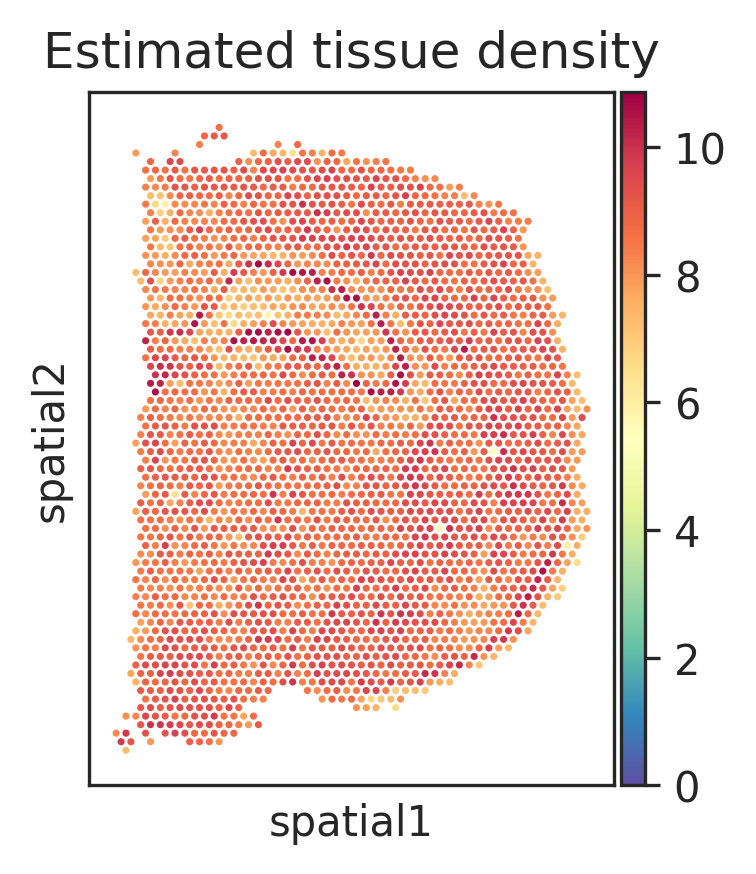

In [25]:
plot_utils.pl_spatial_inf_feature(adata = adata, feature = "ql_m", factor = "Neuron")

... storing 'feature_types' as categorical
... storing 'genome' as categorical
[2025-11-22 13:03:42] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:03:42] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:03:42] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:03:42] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:03:42] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:03:42] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:03:42] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:03:42] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:03:42] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:03:42] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:03:42] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:03:42] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:03:42] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:03:42] findfont: Font family 'FreeSans' not foun

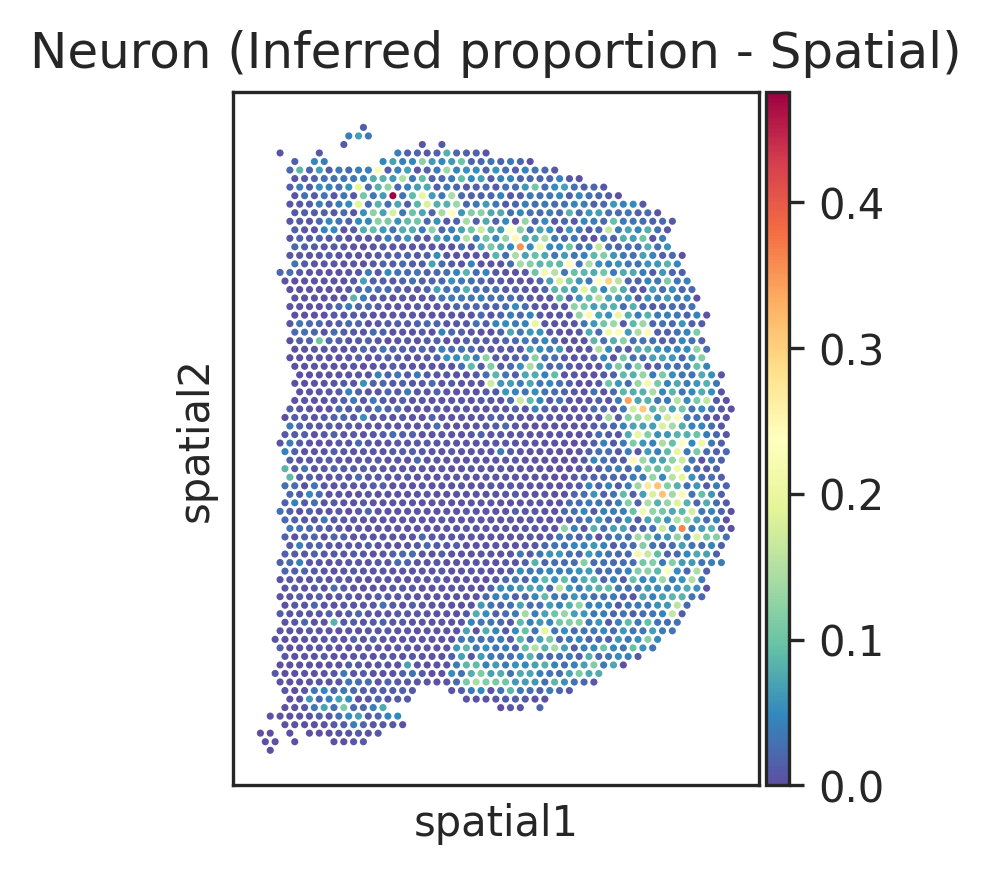

In [26]:
plot_utils.pl_spatial_inf_feature(adata = adata, feature = "qc_m", factor = "Neuron")

(<Figure size 800x600 with 2 Axes>,
 <Axes: title={'center': 'Neuron (Inferred proportion - UMAP of Z)'}>)

[2025-11-22 13:03:58] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:03:58] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:03:58] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:03:58] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:03:58] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:03:58] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:03:58] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:03:58] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:03:58] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:03:58] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:03:58] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:03:58] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:03:58] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:03:58] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:03:58] findfont: Font family 'FreeSans' not found.
[2025-11-2

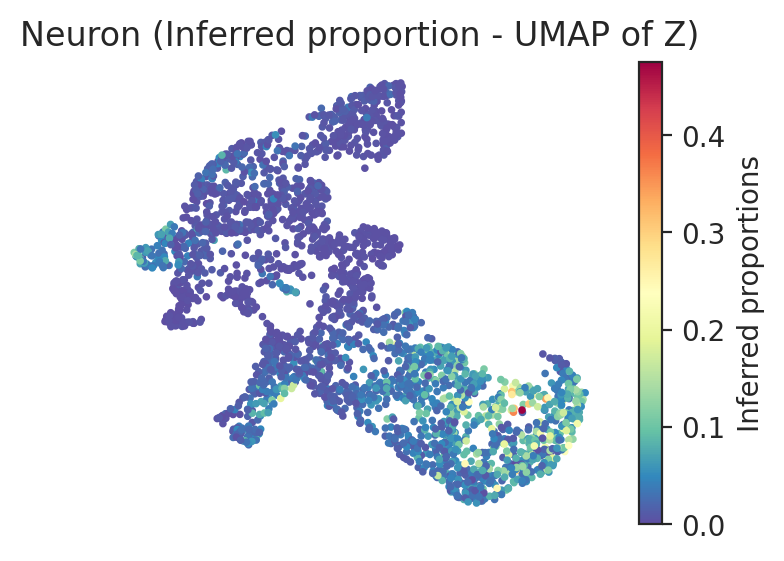

In [27]:
plot_utils.pl_spatial_inf_feature(adata = adata, feature = "qz_m", factor = "Neuron")

In [28]:
pred_exprs = sf_model.model_ct_exp(model,
                                   adata,
                                   visium_args,
                                   device=device)

... storing 'feature_types' as categorical
... storing 'genome' as categorical
[2025-11-22 13:04:04] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:04:04] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:04:04] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:04:04] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:04:04] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:04:04] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:04:04] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:04:04] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:04:04] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:04:04] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:04:04] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:04:04] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:04:04] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:04:04] findfont: Font family 'FreeSans' not foun

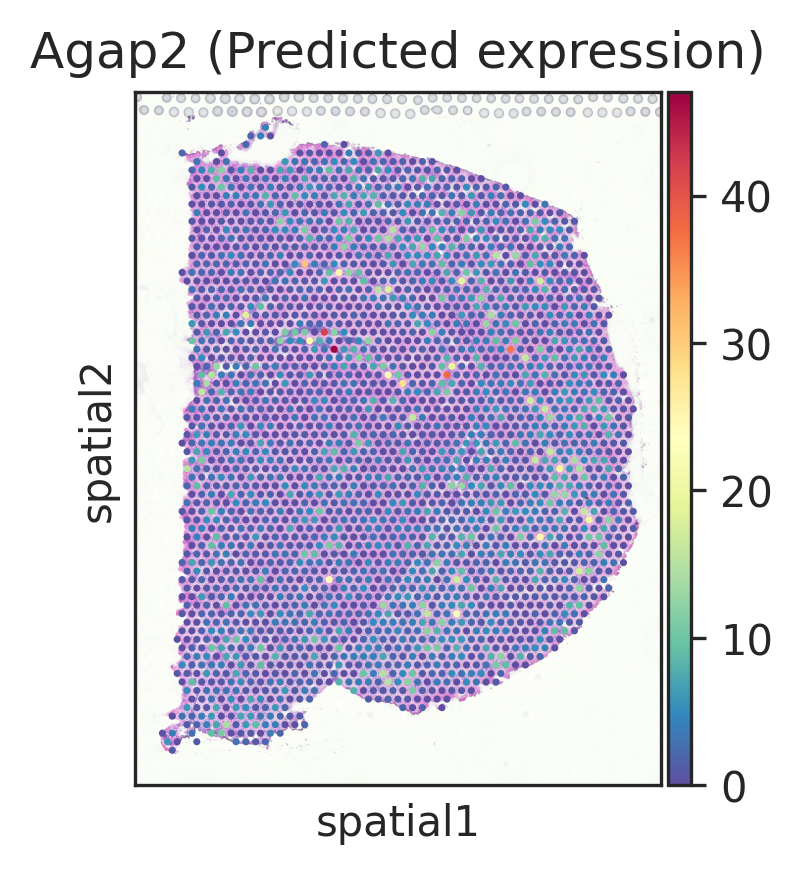

In [29]:
sample_gene = 'Agap2'
sample_cell_type = 'Neuron'

plot_utils.pl_spatial_inf_gene(adata,
                               factor=sample_cell_type,
                               feature=sample_gene,
                               alpha = 0.8        
                              )

In [30]:
# Specify output directory
outdir = '../results/'
if not os.path.exists(outdir):
    os.mkdir(outdir)

# save the model
torch.save(model.state_dict(), os.path.join(outdir, 'starfysh_model.pt'))

# save `adata` object with inferred parameters
adata.write(os.path.join(outdir, 'st.h5ad'))

... storing 'sample' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


In [31]:
import scanpy as sc

adata = sc.read_h5ad("../results/st.h5ad")


In [32]:
adata

AnnData object with n_obs × n_vars = 2702 × 4208
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable'
    uns: 'cell_types', 'neighbors', 'pca', 'qu', 'spatial', 'umap'
    obsm: 'Activated neural stem cell_inferred_exprs', 'Astrocyte_inferred_exprs', 'Basket cell_inferred_exprs', 'Bergmann glial cell_inferred_exprs', 'CCK basket cell_inferred_exprs', 'Cajal-Retzius cell_inferred_exprs', 'Chandelier cell_inferred_exprs', 'Dorsal otocyst_inferred_exprs', 'Early intermediate precursor cell_inferred_exprs', 'Early neuroblast_inferred_exprs', 'Endothelial cell_inferred_exprs', 'Ependymal cell_inferred_exprs', 'Immature olfactory sensory neuron_inferred_exp

In [33]:
adata.obsm["xs_k"]

array([[1.5088484e-06, 6.5376977e-03, 1.5088484e-06, ..., 3.6409441e-02,
        1.2033938e-02, 1.1422619e-02],
       [3.4355114e-06, 1.5188990e-02, 3.4355114e-06, ..., 3.4355114e-06,
        3.4355114e-06, 3.4355114e-06],
       [1.2533357e-02, 3.2234222e-02, 5.3279297e-07, ..., 1.5416645e-03,
        1.8715364e-03, 2.0589631e-02],
       ...,
       [2.1049887e-06, 8.0036655e-02, 2.1049887e-06, ..., 1.0902975e-02,
        2.1049887e-06, 8.6945310e-02],
       [4.3933191e-03, 1.0539896e-01, 2.0404304e-06, ..., 2.0404304e-06,
        2.0404304e-06, 6.8613350e-02],
       [2.4311053e-06, 2.4311053e-06, 7.9271749e-02, ..., 2.7920445e-02,
        2.4311053e-06, 5.2746598e-02]], shape=(2702, 40), dtype=float32)

In [34]:
adata.obsm["qc_m"] #cell type proportions of all spots

array([[0.00671405, 0.01250043, 0.00792252, ..., 0.02874551, 0.00872127,
        0.0171823 ],
       [0.00512264, 0.01813281, 0.00216765, ..., 0.01084217, 0.00397802,
        0.00853059],
       [0.02666913, 0.0389554 , 0.00381956, ..., 0.00265392, 0.00938206,
        0.06095716],
       ...,
       [0.01178795, 0.08667655, 0.00773858, ..., 0.01405377, 0.01406556,
        0.06852087],
       [0.007335  , 0.09765214, 0.00252624, ..., 0.00460516, 0.0032278 ,
        0.02453498],
       [0.00741737, 0.00208811, 0.08931828, ..., 0.03604229, 0.01136178,
        0.0324233 ]], shape=(2702, 40), dtype=float32)

In [35]:
adata.obsm["qc_m"][1] #cell type proportions of one spot!

array([0.00512264, 0.01813281, 0.00216765, 0.01178675, 0.00669128,
       0.0039414 , 0.00949334, 0.01020553, 0.0054193 , 0.18482502,
       0.01515897, 0.00949602, 0.00670718, 0.00354477, 0.00695483,
       0.00496026, 0.08576634, 0.07776257, 0.00992833, 0.01282628,
       0.02668167, 0.00726027, 0.13977014, 0.17359006, 0.01757603,
       0.00229614, 0.00305213, 0.009091  , 0.00534835, 0.0134234 ,
       0.00707288, 0.00669152, 0.05216733, 0.01083969, 0.00253145,
       0.00633354, 0.00203239, 0.01084217, 0.00397802, 0.00853059],
      dtype=float32)

In [36]:
adata.obsm["qc_m"][1].sum() #we can see it sums to almost 1

np.float32(1.0)

[2025-11-22 13:04:37] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:04:37] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:04:37] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:04:37] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:04:37] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:04:37] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:04:37] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:04:37] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:04:37] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:04:37] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:04:37] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:04:37] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:04:37] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:04:37] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:04:37] findfont: Font family 'FreeSans' not found.
[2025-11-2

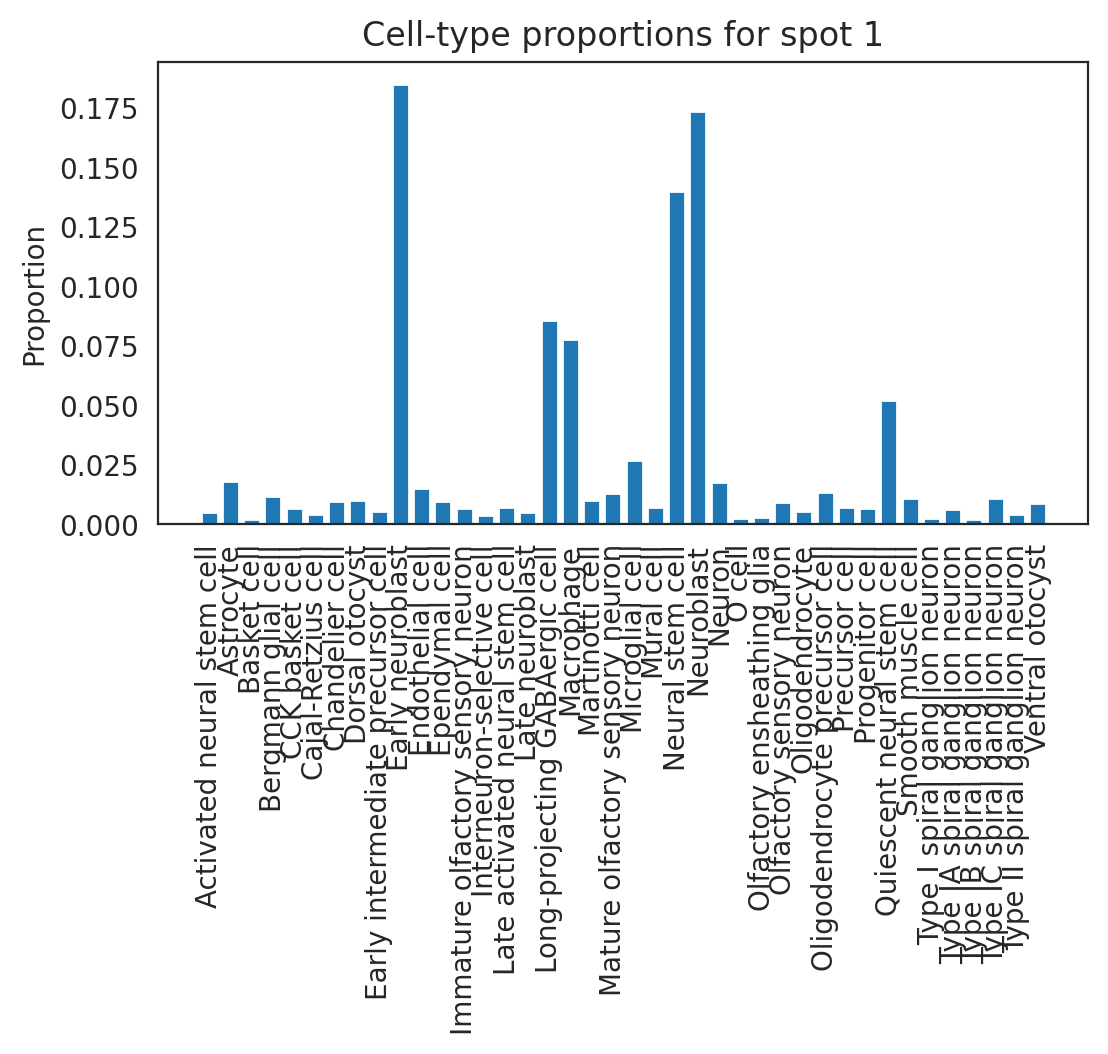

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# values for this spot
vals = adata.obsm["qc_m"][1]               # shape: (n_cell_types,)
cell_types = adata.uns["cell_types"]       # list of length n_cell_types

plt.figure(figsize=(6, 3), dpi=200)
plt.bar(range(len(vals)), vals)

plt.xticks(range(len(vals)), cell_types, rotation=90)
plt.ylabel("Proportion")
plt.title("Cell-type proportions for spot 1")

plt.tight_layout()
plt.show()

okay... looks like mostly early neuroblast! so let's see what the gene expression profile of our neuroblasts are 

In [38]:
print(adata.obsm["Early neuroblast_inferred_exprs"].shape)

(2702, 4208)


In [39]:
adata.obsm["Early neuroblast_inferred_exprs"][1]

array([0., 0., 0., ..., 1., 0., 0.], shape=(4208,), dtype=float32)

In [40]:
print(adata.var_names[adata.obsm["Early neuroblast_inferred_exprs"][1].argmax()])

Hbb-bs


In [41]:
print(adata.obsm["Early neuroblast_inferred_exprs"][1].max())

9.0


According to this, the most highly predicted expressed gene of this cell type in this spot is "Bhlhe40". let's check!

[2025-11-22 13:04:40] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:04:40] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:04:40] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:04:40] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:04:40] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:04:40] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:04:40] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:04:40] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:04:40] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:04:40] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:04:40] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:04:40] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:04:40] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:04:40] findfont: Font family 'FreeSans' not found.
[2025-11-22 13:04:40] findfont: Font family 'FreeSans' not found.
[2025-11-2

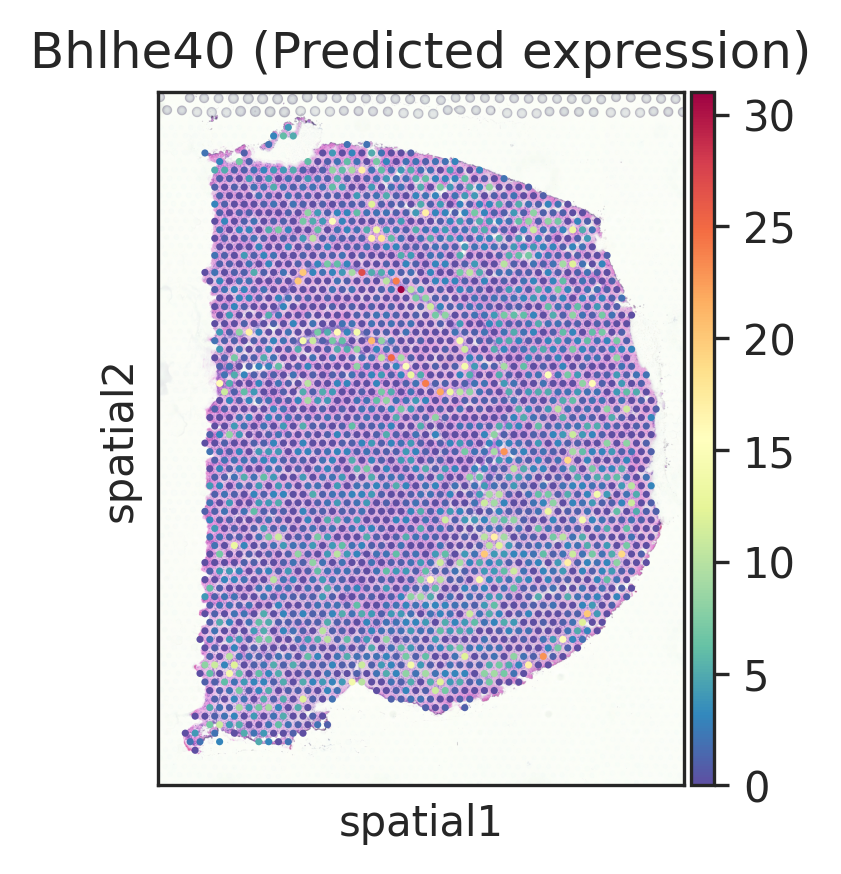

In [42]:
sample_gene = 'Bhlhe40'
sample_cell_type = 'Early neuroblast'

plot_utils.pl_spatial_inf_gene(adata,
                               factor=sample_cell_type,
                               feature=sample_gene,
                               alpha = 0.8        
                              )